In [1]:
# import particles 
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Input
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [5]:
# def next_angle(q, u):
#     # q_init: array (2,) containing the inital angles
#     # u:      array (2,) containing the change rate
#     return q + u

# def current_position(q, l):
#     # q: array (2,) containing the two angles
#     # l: array (2,) containing the limb lengths 
#     x = l * np.cos(q[0]) + l * np.cos(q[0] + q[1])
#     y = l * np.sin(q[0]) + l * np.sin(q[0] + q[1])
#     return np.array([x, y])

def current_position(q, l):
    # q: array (2,) containing the two angles
    # l: array (2,) containing the limb lengths 
    x = l[0] * np.cos(q[0]) + l[1] * np.cos(q[0] + q[1])
    y = l[0] * np.sin(q[0]) + l[1] * np.sin(q[0] + q[1])
    return np.array([x, y])

# Data Simulation

In [11]:
def generate_one_task(limb_length, n_episode=150, n_timesteps=10):
    dof = 2
    angles = list()
    positions = list()
    for _ in range(n_episode):
        q = np.random.uniform(low= -np.pi, high= np.pi, size=dof) # observation, the angle, uniform [-pi, pi]
        angles.append(q)
        u = np.random.randn(dof, n_timesteps) # action, the change rate of angles
        q += u.sum(axis=1)
        position = current_position(q, limb_length)
        positions.append(position)
    
    return positions, angles

In [12]:
n_tasks=1000 
n_episode=150
n_timesteps=10

def simulate_data(n_tasks=1000, n_episode=150, n_timesteps=10):
    angles = list()
    positions = list()
    # generate limb length for each task
    lens = np.random.normal(loc=1, scale=np.sqrt(0.3), size=(n_tasks, 2))
    for i in range(n_tasks):
        position, angle = generate_one_task(lens[i], n_episode=150, n_timesteps=10)
        angles.extend(angle)
        positions.extend(position)

    angles = np.stack(angles, axis=0)
    positions = np.stack(positions, axis=0)

    assert angles.shape == positions.shape # their shape should be both (n_tasks*n_episode*n_timesteps, 2)
    return positions, angles

In [13]:
positions, angles = simulate_data()

In [14]:
positions.shape, angles.shape

((150000, 2), (150000, 2))

In [13]:
np.savez_compressed('./two_link_arm_pretraining_data.npz',x=angles,y=positions)

# Build model

In [15]:
input_length = 2
latent_dim = 512
output_length = 2

model = tf.keras.Sequential([
    Dense(512, activation='relu', input_shape=(input_length,)),
    Dropout(rate=0.5),
    Dense(units=latent_dim, activation='tanh'),
    Dense(units=output_length),
  ])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1536      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 265,218
Trainable params: 265,218
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

# pretraining

In [63]:
loaded = np.load('./two_link_arm_pretraining_data.npz')
# print(np.array_equal(angles , loaded['x']))
# print(np.array_equal(positions , loaded['y']))
angles = loaded['x']
positions = loaded['y']

In [18]:
def train_test_split_reptile(x, y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(np.swapaxes(x.reshape(n_tasks, n_episode, -1),0,1), np.swapaxes(y.reshape(n_tasks, n_episode, -1),0,1), test_size=test_ratio, shuffle = False)
    return x_train.reshape(-1,2), x_test.reshape(-1,2), y_train.reshape(-1,2),y_test.reshape(-1,2)

In [64]:
test_ratio = 0.1

In [71]:
x_train, x_test, y_train, y_test = train_test_split(angles, positions, test_size=test_ratio, random_state=666)
model.fit(x_train, y_train, epochs=5, batch_size=128)

Epoch 1/5
1055/1055 [==============================] - 5s 5ms/step - loss: 0.9519 - mean_absolute_error: 0.7618 - val_loss: 0.5816 - val_mean_absolute_error: 0.5850
Epoch 2/5
1055/1055 [==============================] - 5s 4ms/step - loss: 0.5368 - mean_absolute_error: 0.5597 - val_loss: 0.4297 - val_mean_absolute_error: 0.4977
Epoch 3/5
1055/1055 [==============================] - 5s 5ms/step - loss: 0.4500 - mean_absolute_error: 0.5138 - val_loss: 0.3852 - val_mean_absolute_error: 0.4733
Epoch 4/5
1055/1055 [==============================] - 6s 5ms/step - loss: 0.4162 - mean_absolute_error: 0.4962 - val_loss: 0.3576 - val_mean_absolute_error: 0.4568
Epoch 5/5
1055/1055 [==============================] - 5s 5ms/step - loss: 0.3961 - mean_absolute_error: 0.4852 - val_loss: 0.3504 - val_mean_absolute_error: 0.4554


In [73]:
pretrained = tf.keras.models.load_model('saved_model/my_model')

In [ ]:
# reptile split data by task
x_train, x_test, y_train, y_test = train_test_split_reptile(angles, positions, test_size=test_ratio)
history = model.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_test, y_test))
model.save('./two_link_arm_pretrained_R.model')
with open('./two_link_arm_pretrained_R.history','wb') as f:
    pickle.dump(history.history, f)
    

Epoch 1/200
1055/1055 [==============================] - 7s 6ms/step - loss: 1.1662 - mean_absolute_error: 0.8551 - val_loss: 0.9560 - val_mean_absolute_error: 0.7632
Epoch 2/200
1055/1055 [==============================] - 6s 6ms/step - loss: 0.8701 - mean_absolute_error: 0.7215 - val_loss: 0.7401 - val_mean_absolute_error: 0.6565
Epoch 3/200
1055/1055 [==============================] - 6s 6ms/step - loss: 0.7405 - mean_absolute_error: 0.6607 - val_loss: 0.6383 - val_mean_absolute_error: 0.6068
Epoch 4/200
1055/1055 [==============================] - 6s 6ms/step - loss: 0.6662 - mean_absolute_error: 0.6260 - val_loss: 0.5738 - val_mean_absolute_error: 0.5742
Epoch 5/200
1055/1055 [==============================] - 6s 6ms/step - loss: 0.6193 - mean_absolute_error: 0.6030 - val_loss: 0.5312 - val_mean_absolute_error: 0.5515
Epoch 6/200
1055/1055 [==============================] - 6s 6ms/step - loss: 0.5822 - mean_absolute_error: 0.5842 - val_loss: 0.5015 - val_mean_absolute_error: 0.536

In [38]:
loss = history.history['loss']

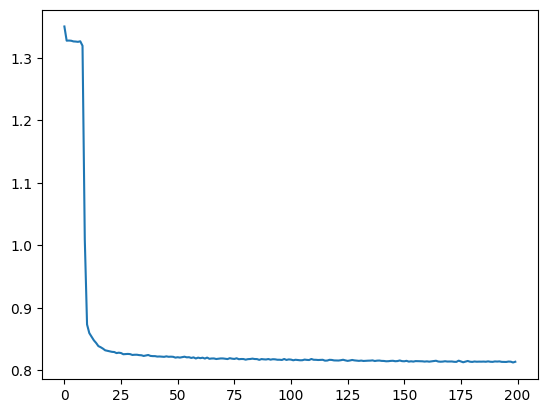

In [39]:
plt.plot(loss)

In [17]:
def plot_model(model):
    loss = model.history.history['loss']
    plt.plot(loss)

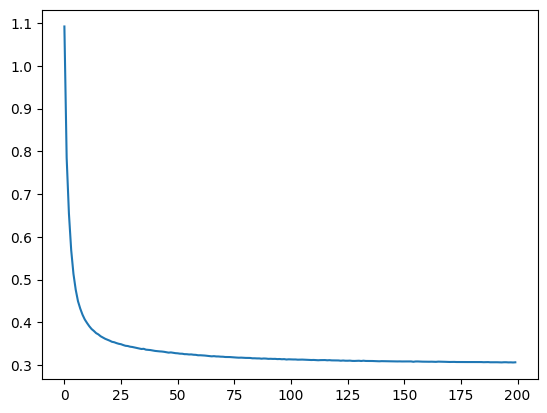

In [18]:
plot_model(model)